In [8]:
import requests
import py2neo
import sys
import os
from py2neo import Graph


In [9]:
#!export CITIZEN_API_KEY=vtknESKIUfi2
API_KEY      = os.environ.get('CITIZEN_API_KEY', "YOUR_API_KEY_HERE")
NEO_URL      = os.environ.get('CITIZEN_NEO_URL', "http://localhost:7474/")
NEO_USER     = os.environ.get('CITIZEN_NEO_USER', "neo4j")
NEO_PASSWORD = os.environ.get('CITIZEN_NEO_PASSWORD', "YOUR NEO4J PASSWORD HERE")

In [10]:
DOMAIN = "https://www.CitizenAudit.org/api/v1/api_key/" + API_KEY
SEARCH_ORGANIZATIONS_ENDPOINT = DOMAIN + "/search/organizations/"
SEARCH_GRANTS_ENDPOINT = DOMAIN + "/search/grants/"
SEARCH_CONTRACTS_ENDPOINT = DOMAIN + "/search/contracts/"

In [11]:
graph = Graph(NEO_URL, user=NEO_USER, password=NEO_PASSWORD)

### What foundations show up in Trumpworld?

In [51]:
def getFoundationNames():
    QUERY = '''
       MATCH (o:Organization)
         WHERE o.name CONTAINS "FOUNDATION" OR
           o.name CONTAINS "UNIVERSITY" OR
           o.name CONTAINS "HOSPITAL"
       RETURN o.name AS name ORDER BY name'''
    
    result = graph.run(QUERY)
    names = []
    for record in result:
        names.append(record['name'])
    return names

nonprofits = getFoundationNames()
print("Found " + str(len(nonprofits)) + " possible nonprofits.")
print(nonprofits)

Found 69 possible nonprofits.
['ASIA PACIFIC FOUNDATION OF CANADA', 'BLENHEIM FOUNDATION USA', 'BRAIN TRAUMA FOUNDATION', 'CEDAR SINAI HOSPITAL', 'CLARENT HOSPITAL CORP.', 'CLOSE UP FOUNDATION', 'DICK & BETSY DEVOS FAMILY FOUNDATION', 'DJT UNIVERSITY MANAGING MEMBER LLC', 'DJT UNIVERSITY MEMBER LLC', 'DUKE UNIVERSITY', 'DUKE UNIVERSITY HEALTH SYSTEM, INC.', 'ELAINE T. COOPER FOUNDATION', 'EMORY UNIVERSITY SCHOOL OF MEDICINE', 'FOUNDATION FOR EXCELLENCE IN EDUCATION', 'GRADY MEMORIAL HOSPITAL', 'GREAT LAKES EDUCATION FOUNDATION', 'GREAT NORTHERN VETERANS PEACE PARK FOUNDATION', 'HARVARD UNIVERSITY COMMITTEE ON UNIVERSITY RESOURCES', 'HOWARD UNIVERSITY', 'INDIANA POLICY REVIEW FOUNDATION', 'INTERNATIONAL LEADERSHIP FOUNDATION', 'JAMESTOWN FOUNDATION', 'JOHNS HOPKINS UNIVERSITY', 'LAPD FOUNDATION', 'LEXINGTON MEDICAL CENTER FOUNDATION', "LEXINGTON SHERIFF'S FOUNDATION", 'MARINE CORPS SCHOLARSHIP FOUNDATION', 'MULTIPLE MYELOMA RESEARCH FOUNDATION', 'NATIONAL DEFENSE UNIVERSITY', 'NEW YORK 

## Introducing CitizenAudit API

* what it is
* what data is available / where the data comes from
* Introduce the API

### Citizen Audit API Endpoints


#### Search for an organization
SEARCH_ORGANIZATIONS_ENDPOINT = DOMAIN + "/search/organizations/"

* An example using requests

#### Search for grants
SEARCH_GRANTS_ENDPOINT = DOMAIN + "/search/grants/"

* An example using requests


#### Search for contracts
SEARCH_CONTRACTS_ENDPOINT = DOMAIN + "/search/contracts/"

* An example using requests

In [7]:
# orgname    
# {assets, contact, date, descrip, ein, name, other_names, state}
WRITE_NONPROFIT_QUERY = '''
MATCH (o:Organization) WHERE o.name = $orgname
MERGE (n:Nonprofit {ein: $ein})
SET           n.assets      = toInt($assets),
              n.date        = $date,
              n.descrip     = $descrip,
              n.name        = $name,
              n.other_names = $other_names,
              n.state       = $state
MERGE (o)<-[:SIMILAR_NAME]-(n)
RETURN COUNT(*) AS nonprofit_created
'''


# {Grantee_EIN, Grantee_Grant_Amount, Grantee_Grant_Purpose, 
#  Grantee_Name, Grantor_EIN, Grantor_Name,
#  Grantor_Tax_Year}
WRITE_GRANTS_QUERY = '''
WITH $grants AS grants
UNWIND grants AS grant
MERGE (grantee:Nonprofit {ein: grant.Grantee_EIN})
ON CREATE SET grantee.name = grant.Grantee_Name
MERGE (grantor:Nonprofit {ein: grant.Grantor_EIN})
ON CREATE SET grantor.name = grant.Grantor_Name
CREATE (g:Grant)
SET g.purpose = grant.Grantee_Grant_Purpose,
    g.amount  = toFloat(grant.Grantee_Grant_Amount),
    g.year    = toInt(grant.Grantor_Tax_year)
MERGE (grantee)<-[:GRANTEE]-(g)-[:GRANTOR]->(grantor)
RETURN COUNT(*) AS grants_written
'''

# { Contractor, Contractor_Compensation_Amount, Contractor_Service_Type, 
# Nonprofit_EIN, Nonprofit_Name, Nonprofit_Tax_Year }
WRITE_CONTRACTS_QUERY = '''
WITH $contracts AS contracts
UNWIND contracts AS contract
MERGE (contractor:Organization {name: contract.Contractor})
WITH *
MATCH (n:Nonprofit {ein: contract.Nonprofit_EIN})
CREATE (c:Contract)
SET c.amount       = contract.Contractor_Compensation_Amount,
    c.service_type = contract.Contractor_Service_Type,
    c.year         = contract.Nonprofit_Tax_Year
MERGE (n)-[:ISSUED_CONTRACT]->(c)<-[:AWARDED_CONTRACT]-(contractor)
RETURN COUNT(*) AS contracts_written
'''


# Search for a non-profit, given a name
def searchOrg(org):
    # result fields: assets, contact, date, 
    #                descrip, ein, name, other_ames, state
    params = {"name": org}
    r = requests.get(SEARCH_ORGANIZATIONS_ENDPOINT, params=params)
    orgs = r.json()
    match = orgs[0]
    match['orgname'] = org
    #print(orgs)
    print(match['ein'])
    print(match['name'])
    print(match['state'])
    print(match['other_names'])
    
    if not "assets" in match:
        match["assets"] = ""
    
    graph.run(WRITE_NONPROFIT_QUERY, parameters=match).dump()
    
    searchGrantor(match['ein'])
    searchGrantee(match['ein'])
    searchContracts(match['name'])

# Search for grantor, given an EIN
def searchGrantor(ein):
    # result fields: Grantee_EIN, Grantee_Grant_Amount, Grantee_Grant_Purpose, Grantee_Name, Grantor_EIN, Grantor_Name,
    #                Grantor_Tax_Year
    params = {"query": ein, "query_fields": "Grantor_EIN", "query_operator": "AND"}
    r = requests.get(SEARCH_GRANTS_ENDPOINT, params=params)
    grants = r.json()
    #print(r.text)
    #print(r.status_code)
    #print(r.url)
    
    if "Grantee_EIN" in grants[0]:
        graph.run(WRITE_GRANTS_QUERY, parameters={"grants": grants}).dump()
        print("WROTE GRANTORS")
    
    
# Search grantee, given an EIN
def searchGrantee(ein):
    # result fields: Grantee_EIN, Grantee_Grant_Amount, Grantee_Grant_Purpose, Grantee_Name, Grantor_EIN, Grantor_Name,
    #                Grantor_Tax_Year
    params = {"query": ein, "query_fields": "Grantee_EIN", "query_operator": "AND"}
    r = requests.get(SEARCH_GRANTS_ENDPOINT, params=params)
    grants = r.json()
    #print(r.text)
    #print(r.status_code)
    #print(r.url)
    
    if "Grantee_EIN" in grants[0]:
        graph.run(WRITE_GRANTS_QUERY, parameters={"grants": grants}).dump()
        print("WROTE GRANTEES")
    
    
def searchContracts(name):
    # result fields: Contractor, Contractor_Compensation_Amount, Contractor_Service_Type, Nonprofit_EIN, Nonprofit_Name,
    #                Nonprofit_Tax_Year
    params = {"query": name, "query_fields": "Nonprofit_Name", "query_operator": "AND"}
    r = requests.get(SEARCH_CONTRACTS_ENDPOINT, params=params)
    contracts = r.json()
    
    print(r.text)
    print(r.status_code)
    print(r.url)
    
    if "Contractor" in contracts[0]:
        graph.run(WRITE_CONTRACTS_QUERY, parameters={"contracts": contracts}).dump()
    
    
   

In [4]:
# searchOrg("Dick And Betsy Devos Family Foundation")

In [45]:
n = getFoundationNames()
print(n)
for name in n:
    print("SEARCHING: " + name)
    searchOrg(name)
    print("------------------------------")

['ASIA PACIFIC FOUNDATION OF CANADA', 'BLENHEIM FOUNDATION USA', 'BRAIN TRAUMA FOUNDATION', 'CEDAR SINAI HOSPITAL', 'CLARENT HOSPITAL CORP.', 'CLOSE UP FOUNDATION', 'DICK & BETSY DEVOS FAMILY FOUNDATION', 'DJT UNIVERSITY MANAGING MEMBER LLC', 'DJT UNIVERSITY MEMBER LLC', 'DUKE UNIVERSITY', 'DUKE UNIVERSITY HEALTH SYSTEM, INC.', 'ELAINE T. COOPER FOUNDATION', 'EMORY UNIVERSITY SCHOOL OF MEDICINE', 'FOUNDATION FOR EXCELLENCE IN EDUCATION', 'GRADY MEMORIAL HOSPITAL', 'GREAT LAKES EDUCATION FOUNDATION', 'GREAT NORTHERN VETERANS PEACE PARK FOUNDATION', 'HARVARD UNIVERSITY COMMITTEE ON UNIVERSITY RESOURCES', 'HOWARD UNIVERSITY', 'INDIANA POLICY REVIEW FOUNDATION', 'INTERNATIONAL LEADERSHIP FOUNDATION', 'JAMESTOWN FOUNDATION', 'JOHNS HOPKINS UNIVERSITY', 'LAPD FOUNDATION', 'LEXINGTON MEDICAL CENTER FOUNDATION', "LEXINGTON SHERIFF'S FOUNDATION", 'MARINE CORPS SCHOLARSHIP FOUNDATION', 'MULTIPLE MYELOMA RESEARCH FOUNDATION', 'NATIONAL DEFENSE UNIVERSITY', 'NEW YORK CITY POLICE FOUNDATION', 'NEW 

### Nonprofits that share contractors

MATCH p=(n1:Nonprofit)-[:ISSUED_CONTRACT]->(:Contract)<-[:AWARDED_CONTRACT]-(o:Organization)-[:AWARDED_CONTRACT]-(:Contract)<-[:ISSUED_CONTRACT]-(n2:Nonprofit)
WHERE n1<>n2
RETURN o,n1,n2

### Nonprofits that share grantees

### Receipients of contracts / grants from Trump foundation

### TODO: Analysis using pandas / matplotlib
* distribution of grant size
* 

In [14]:
from pandas import DataFrame
%matplotlib inline

In [16]:

all_contracts = DataFrame(graph.data('''
MATCH (grantor:Nonprofit)<-[:GRANTOR]-(grant:Grant)-[:GRANTEE]->(grantee:Nonprofit)
RETURN grantor.name AS grantor, grantor.assets AS grantor_assets, grant.amount AS amount, 
grant.purpose AS purpose, grantee.name AS grantee, grantee.assets AS grantee_assets
'''
))

all_contracts[:5]

,amount,grantee,grantee_assets,grantor,grantor_assets,purpose
0,17332.0,THE BLENHEIM FOUNDATION UNITED KINGDOM,NaN,Mm & Ctw Foundation Inc,1195696.0,ASSISTANCE TO INDIGENT FAMILIES AND RELIGIOUS ...
1,28538.0,THE BLENHEIM FOUNDATION UNITED KINGDOM,NaN,Mm & Ctw Foundation Inc,1195696.0,ASSISTANCE TO INDIGENT FAMILIES AND RELIGIOUS ...
2,40420.0,THE BLENHEIM FOUNDATION UNITED KINGDOM,NaN,Mm & Ctw Foundation Inc,1195696.0,ASSISTANCE TO INDIGENT FAMILIES AND RELIGIOUS ...
3,22744.0,THE BLENHEIM FOUNDATION UNITED KINGDOM,NaN,Mm & Ctw Foundation Inc,1195696.0,ASSISTANCE TO INDIGENT FAMILIES AND RELIGIOUS ...
4,53953.0,THE BLENHEIM FOUNDATION UNITED KINGDOM,NaN,Mm & Ctw Foundation Inc,1195696.0,ASSISTANCE TO INDIGENT FAMILIES AND RELIGIOUS ...


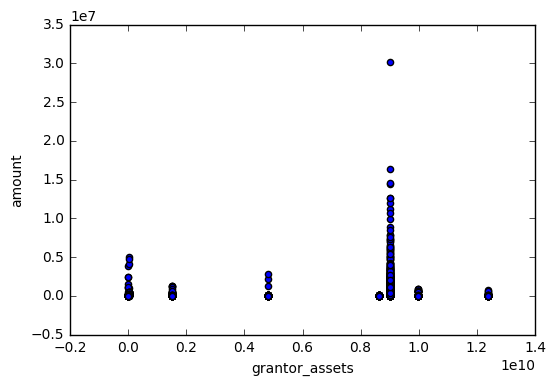

In [20]:
#avg_zips.plot.bar(x="neighborhood")
all_contracts.plot.scatter(x="grantor_assets", y="amount")